In [1]:
import pystare as ps

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs

import numpy

In [2]:
# Some helper functions for plotting & printing.

class figax_container(object):
    def __init__(self,figax):
        self.fig = figax[0]
        self.ax  = figax[1]
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options={'projection':ccrs.PlateCarree(),'transform':ccrs.Geodetic()}
        ,set_global=False
        ,show=True
        ,color=None
        ):

    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options))
        if set_global:
            figax.ax.set_global()
        figax.ax.coastlines()
    else:
        ax = figax.ax
    
    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        figax.ax.triplot(siv_triang,c=color,transform=plot_options['transform'])
    
    if show:
        plt.show()
        
    return figax

def hex16(i):
    return "0x%016x"%i

km  = 1 # Unit of length
deg = 1 # Unit of angle

In [3]:
# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

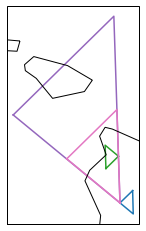

In [4]:
spatial_index_MaunaLoa  = 0x2c2401f47797ec49 # Mauna Loa ~ 20 km
spatial_index_Waikoloa  = 0x2c321dafde0f61a9 # Waikoloa  ~ 20 km
spatial_index_Haleakala = 0x2c326749360621c6 # Haleakala ~ 160 km

# Set up a test index using a resolution 7 (~80 km) neighborhood of Waikoloa
test_index = spatial_index_Waikoloa - 2 # Go 2 levels coarser (2**2 times larger)

figax = hello_plot([spatial_index_MaunaLoa],show=False)        # Small Blue
figax = hello_plot([spatial_index_Waikoloa],figax,show=False)  # Small Green
figax = hello_plot([spatial_index_Haleakala],figax,show=False) # Big Purple

figax = hello_plot([test_index],figax) # Medium Pink


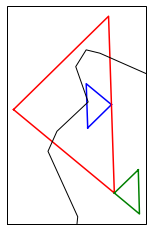

In [5]:
# Try out cmp_spatial for the simple case of 1 element arrays (or lists).

# Set up the colors to indicate the results of pystare.cmp_spatial([a...],[b...])
def contains_color(i):
    "Return a color based on the input. Works if i isa numpy array."
    ret = 'k'
    if i == -1:   # for a in b
        ret = 'r'
    elif i == 0:  # neither a nor b contains the other
        ret = 'g'
    elif i == 1:  # for b in a
        ret = 'b'
    return ret

# Check to see if test_index contains Waikoloa. Test contains Waikoloa so it's blue.
figax = hello_plot([spatial_index_Waikoloa]
                   ,color=contains_color(
                       ps.cmp_spatial([test_index],[spatial_index_Waikoloa])) # test contains waikoloa?
                   ,show=False)

# Check to see if Waikoloa contains test_index. Test contains Waikoloa so color Test red.
figax = hello_plot([test_index],figax
                   ,color=contains_color(
                       ps.cmp_spatial([spatial_index_Waikoloa],[test_index])) # waikoloa contains test?
                   ,show=False)

# Check to see if test_index contains Mauna Loa. Mauna Loa is outside Test, so color Mauna Loa green.
figax = hello_plot([spatial_index_MaunaLoa],figax
                   ,color=contains_color(
                       ps.cmp_spatial([test_index],[spatial_index_MaunaLoa])) # test contains M. Loa?
                   ,show=True)


Test contains Waikoloa? result = 1, color = b 
Test contains Mauna Loa? result = 0, color = g 
Test contains Haleakala? result = -1, color = r 
Test contains Test? result = 1, color = b 


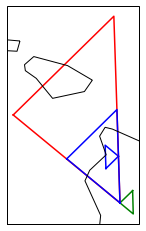

In [6]:
# Show a simple use of a STARE spatial index as a key.
# Note, this approach can become very sophisticated.

query_names   = {spatial_index_Waikoloa:  'Waikoloa'
                ,spatial_index_MaunaLoa:  'Mauna Loa'
                ,spatial_index_Haleakala: 'Haleakala'
                ,test_index:              'Test'}

# Show a simple use of cmp_spatial's 'exterior' product.
test_results = dict(zip(query_names.keys()
                        ,ps.cmp_spatial([test_index]
                                        ,list(query_names.keys()))))

# Initialize the plot
figax = hello_plot(show=False)

# Loop over the results
for qi in query_names:
    figax = hello_plot([qi],figax
                   ,color=contains_color(test_results[qi])
                   ,show=False)
    print('%s contains %s? result = %i, color = %s '
          %(query_names[test_index]
            ,query_names[qi]
            ,test_results[qi]
            ,contains_color(test_results[qi])))
plt.show()

# Note cmp_spatial([test_index],[test_index]), i.e. test_index contains test_index
# 'short circuits' to '1'.
# Note 'Haleakala' contains Test, hence cmp_spatial returns -1.